# MultiVisit Analysis of HD106315b

We have analysed two visits of HD106315 individually -- now we will use `pycheops.MultiVisit` to analyse both of the visits simultaneously.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser

Let's load the saved datasets using `MultiVisit` class.

In [2]:
M = pycheops.MultiVisit('HD 106315', ident='none')


 N  file_key                   Aperture last_ GP  Glint pipe_ver
 ---------------------------------------------------------------------------
  1 CH_PR100041_TG000802_V0200 OPTIMAL  lmfit No  Yes   13.1.0
  2 CH_PR100041_TG001401_V0200 OPTIMAL  lmfit No  Yes   13.1.0


In [3]:
rprs = np.random.normal(0.01728, 0.0006, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(6277, 51.5, 10000)
logg = np.random.normal(4.25, 0.02, 10000)
mh = np.random.normal(-0.22, 0.07, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])

In [4]:
# I have tried this with nroll=3, but it is better with nroll=1 (Delta  BIC = ~200)
TJD_0 = M.tzero(2457586.5267, 9.55237)
result = M.fit_transit(unroll=True, nroll=1,
                       extra_priors={
                           'T_0':ufloat(TJD_0,0.1),
                           'logrho':ufloat(-0.229,0.045)},
                       burn=1024, steps=512, nwalkers=256) 

Running burn-in ..


100%|██████████| 1024/1024 [15:14<00:00,  1.12it/s]

Running sampler ..



100%|██████████| 512/512 [08:27<00:00,  1.01it/s]


In [5]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 388447
    # data points      = 3376
    # variables        = 15
    chi-square         = 6369.99519
    reduced chi-square = 1.89526783
    Akaike info crit   = -44786.4847
    Bayesian info crit = -44694.6180
    RMS residual       = 323.5 ppm
[[Variables]]
    D:               2.9540e-04 +/- 1.6715e-05 (5.66%) (init = 0.0003098181)
    W:               0.01611392 +/- 4.4162e-04 (2.74%) (init = 0.01518939)
    b:               0.61949496 +/- 0.04743382 (7.66%) (init = 0.6758056)
    P:               9.552105 (fixed)
    T_0:             1952.49917 +/- 0.00202529 (0.00%) (init = 1952.483)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    h_1:             0.7686309 (fixed)
    h_2:             0.4615763 (fixed)
    k:               0.01718722 == 'sqrt(D)'
    aR:              15.9369351 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99924421 == 'sqrt(1 - (b/aR)**2)'
    logrho:         -0.2

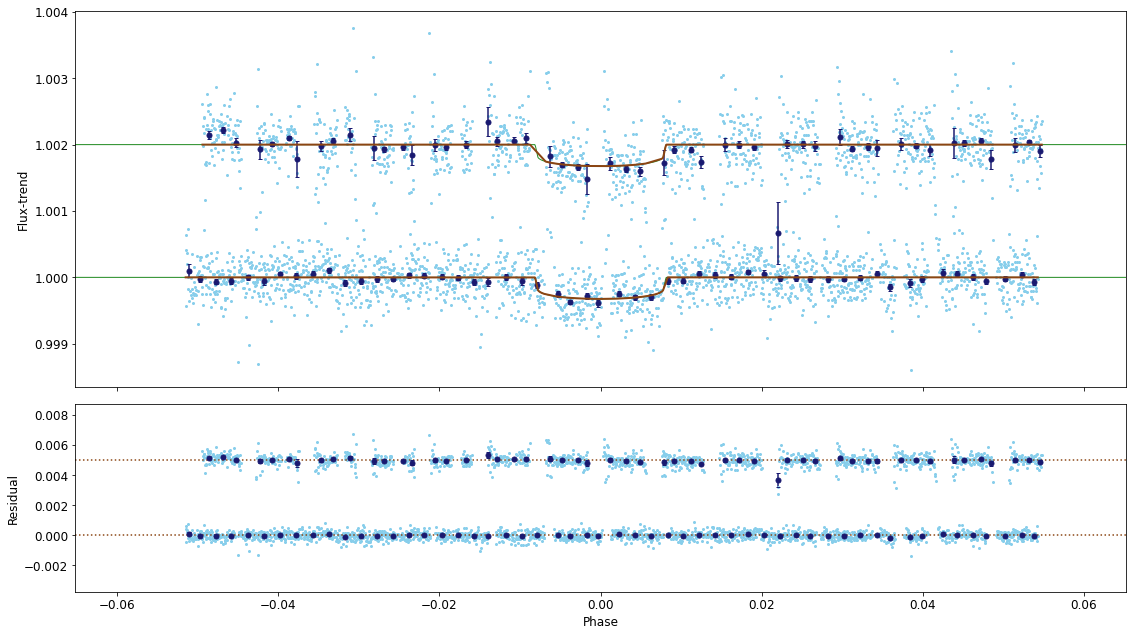

In [6]:
M.plot_fit(binwidth=0.002, data_offset=0.002, res_offset=0.005, detrend=True, figsize=(16,9));

## Trend of Roll-Anlge with time

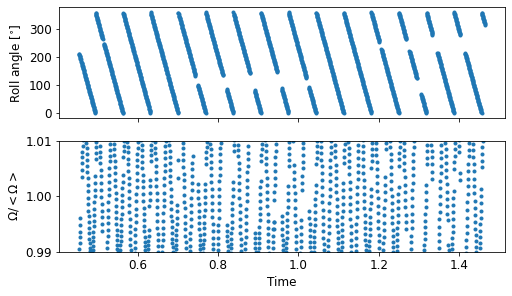

In [7]:
fig,ax = plt.subplots(figsize=(8,4.5),nrows=2,sharex=True)
t = M.datasets[0].lc['time']
t0 = np.floor(t[0])
roll_angle = M.datasets[0].lc['roll_angle']
ax[0].plot(t-t0,roll_angle,'.')
ax[0].set_ylabel('Roll angle [$^{\circ}$]')
drdt = np.gradient(roll_angle)
Omega = np.nanmedian(drdt)
ax[1].plot(t-t0,drdt/Omega,'.')
ax[1].set_ylim(0.99,1.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('$\Omega/<\Omega>$');

Wow! The variations can be indeed high! We can remove this correlations as follows:

 - We can either ignore it (only if trends are not large)
 - We can increase nroll (upto which harmonics of roll angle we want to include in decorrelation)
 - Or we can remove the prior decorrelation first and then fit for it (using `unwrap=True`).

In [8]:
result = M.fit_transit(unroll=True, nroll=1, unwrap=True,
                       extra_priors={
                           'T_0':ufloat(TJD_0,0.1),
                           'logrho':ufloat(-0.229,0.045)},
                       burn=1024, steps=512, nwalkers=256)

Running burn-in ..


100%|██████████| 1024/1024 [15:24<00:00,  1.11it/s]

Running sampler ..



100%|██████████| 512/512 [06:15<00:00,  1.36it/s]


In [9]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 379154
    # data points      = 3376
    # variables        = 15
    chi-square         = 7227.47479
    reduced chi-square = 2.15039417
    Akaike info crit   = -44907.6488
    Bayesian info crit = -44815.7821
    RMS residual       = 329.5 ppm
[[Variables]]
    D:               2.9578e-04 +/- 1.6075e-05 (5.43%) (init = 0.0003098181)
    W:               0.01612793 +/- 2.9151e-04 (1.81%) (init = 0.01518939)
    b:               0.61708222 +/- 0.04062701 (6.58%) (init = 0.6758056)
    P:               9.552105 (fixed)
    T_0:             1952.49832 +/- 0.00140415 (0.00%) (init = 1952.483)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    h_1:             0.7686309 (fixed)
    h_2:             0.4615763 (fixed)
    k:               0.01719830 == 'sqrt(D)'
    aR:              15.9598173 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99925224 == 'sqrt(1 - (b/aR)**2)'
    logrho:         -0.2

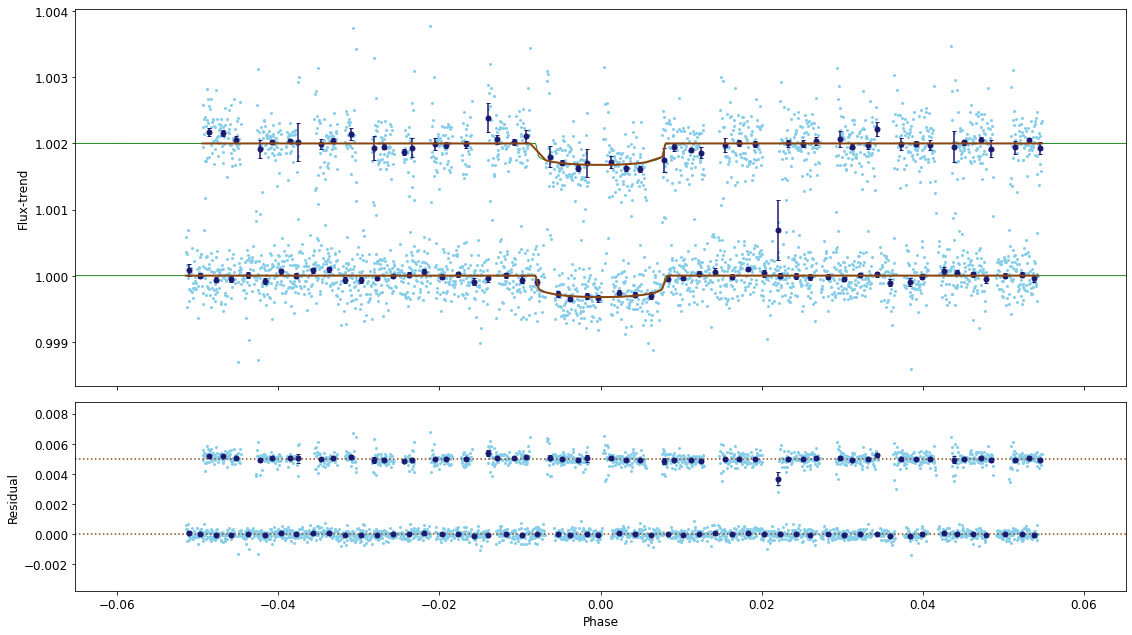

In [10]:
M.plot_fit(binwidth=0.002, data_offset=0.002, res_offset=0.005, detrend=True, figsize=(16,9));

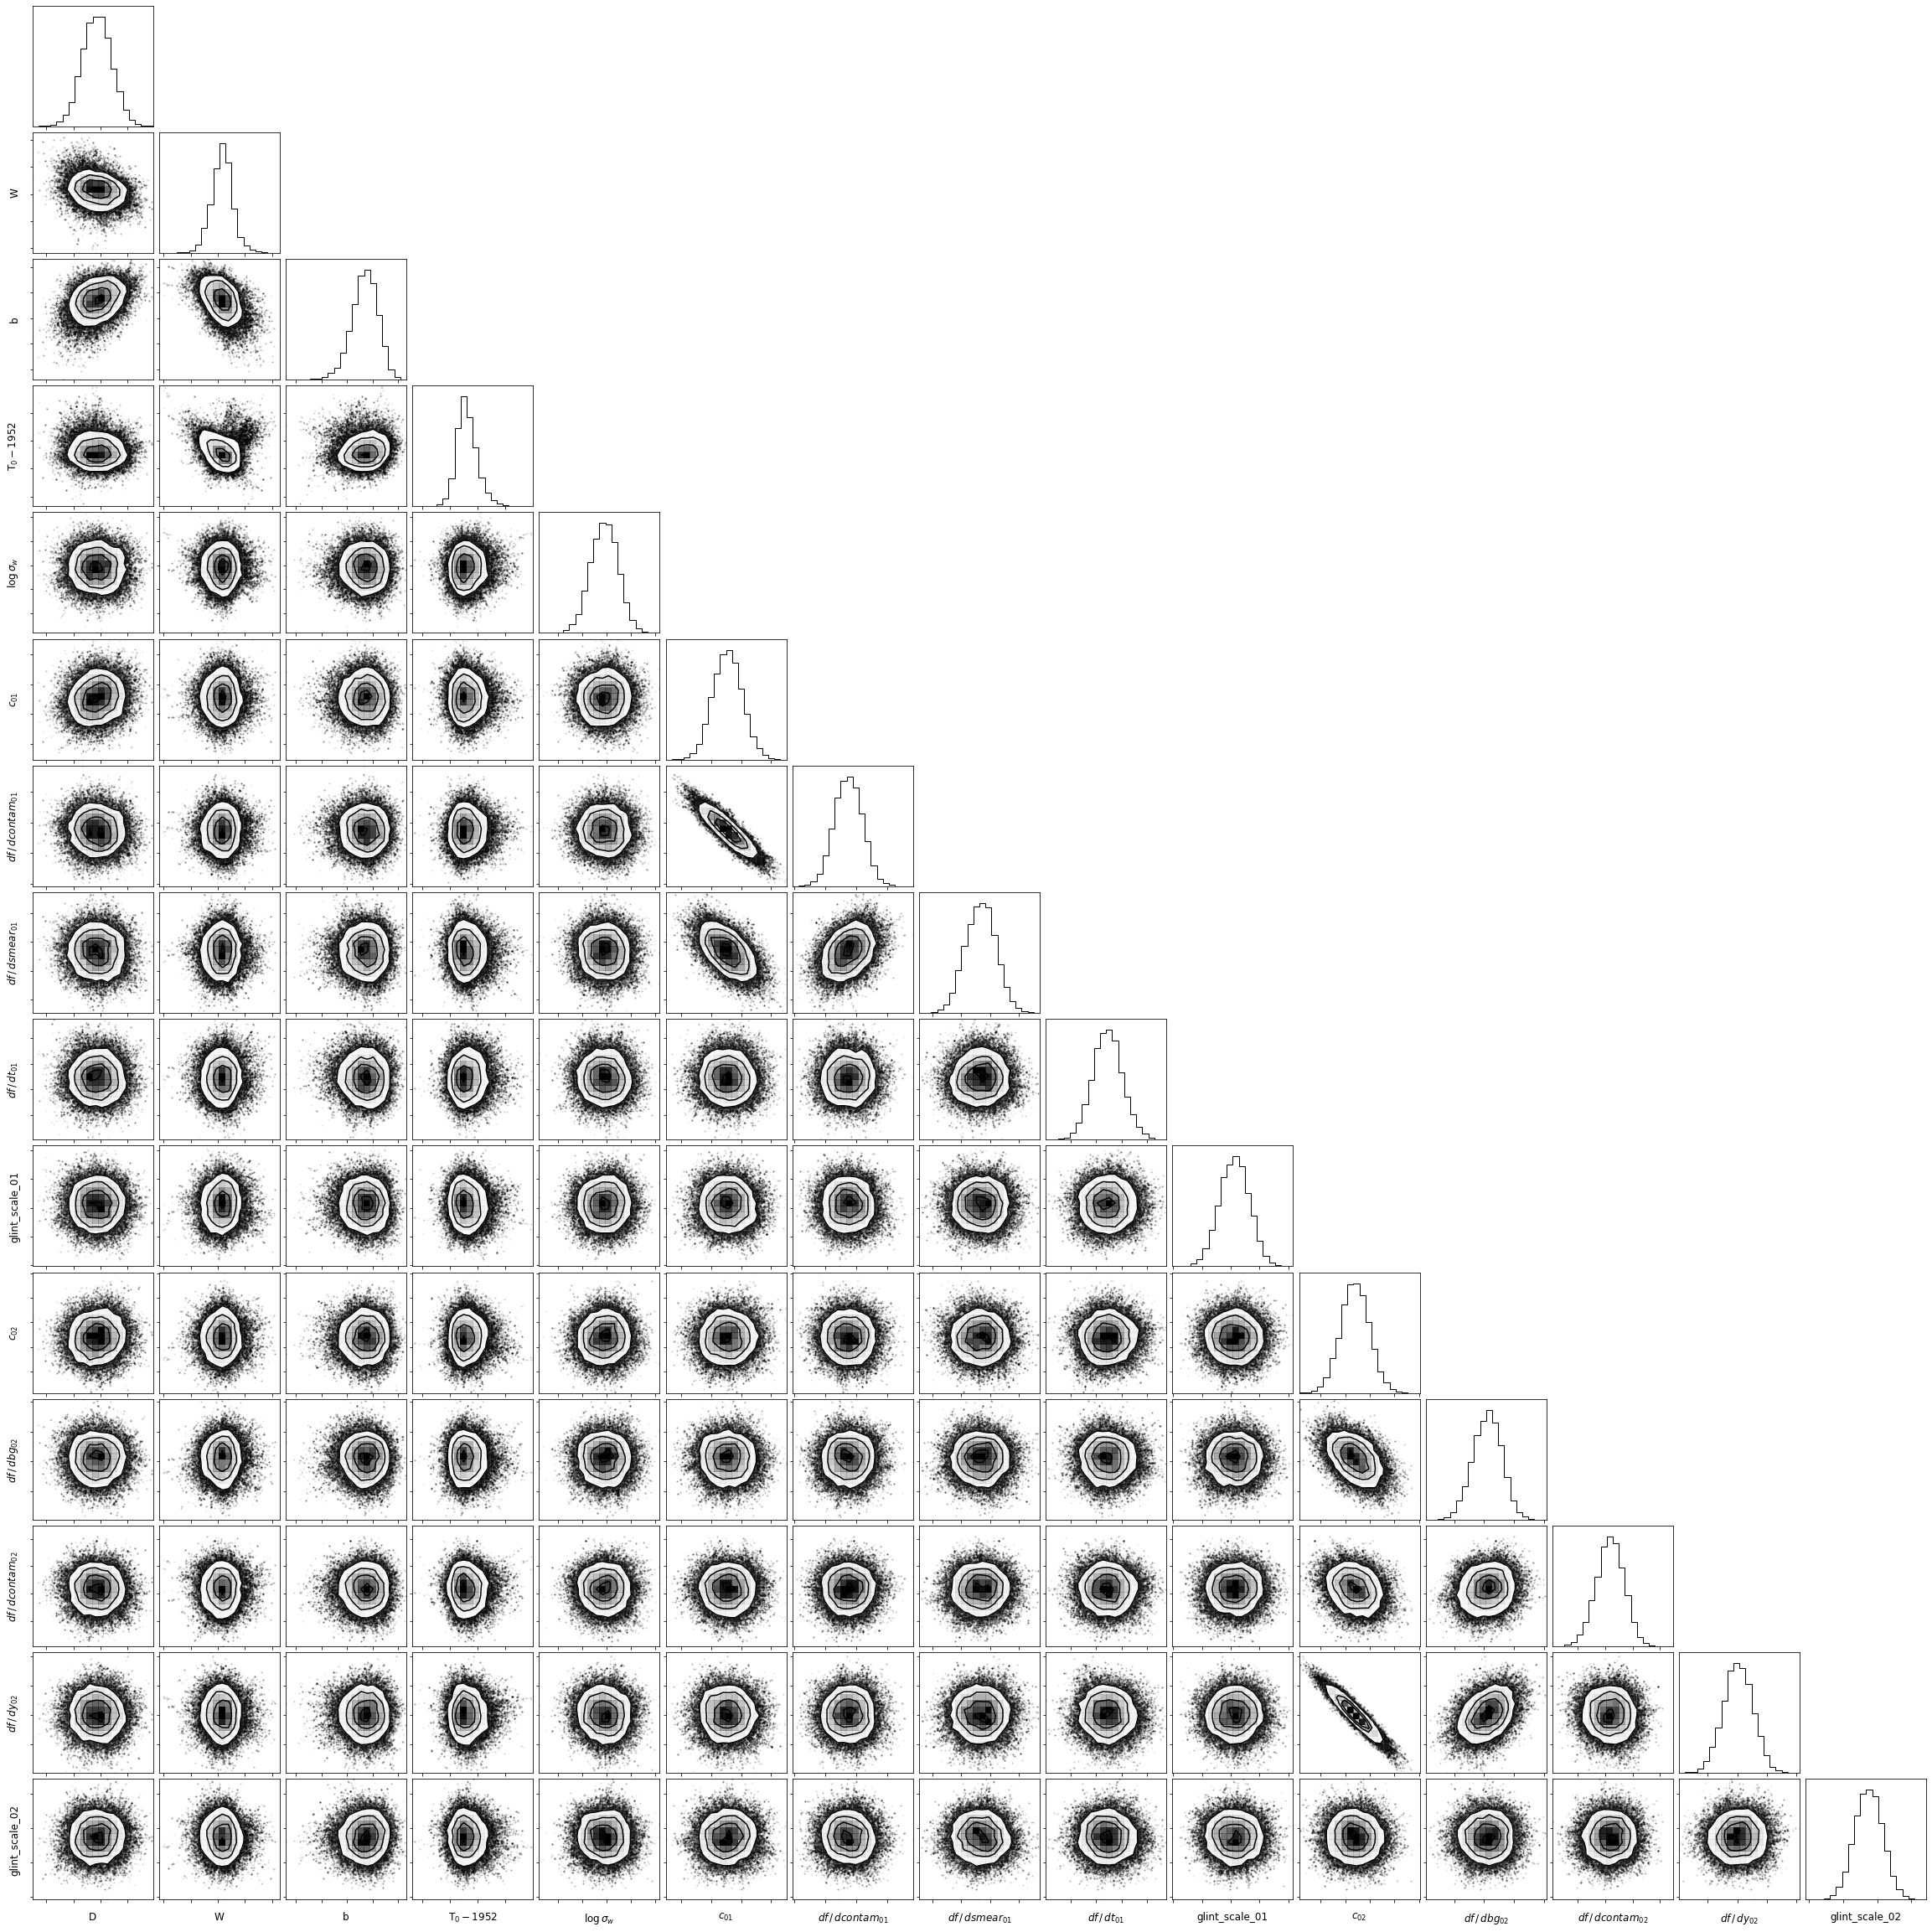

In [11]:
M.corner_plot(plotkeys='all');

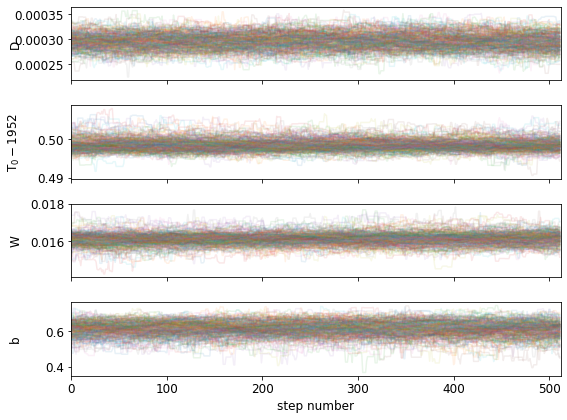

In [12]:
M.trail_plot();

In [13]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
D,2.9578e-04,1.6075e-05,(5.43%),0.0003098180502292629,7.4672e-05,0.00119597,True,
W,0.01612793,2.9151e-04,(1.81%),0.015189387482257006,0.00411668,0.06586681,True,
b,0.61708222,0.04062701,(6.58%),0.675805557301582,0.00000000,1.00000000,True,
P,9.55210500,,(6.58%),9.552105,0.00000000,inf,False,
T_0,1952.49832,0.00140415,(0.00%),1952.4832340216701,1952.41069,1952.55578,True,
f_c,0.00000000,,(0.00%),0.0,-1.00000000,1.00000000,False,
f_s,0.00000000,,(0.00%),0.0,-1.00000000,1.00000000,False,
h_1,0.76863086,,(0.00%),0.7686308585941712,0.00000000,1.00000000,False,
h_2,0.46157627,,(0.00%),0.4615762712077681,0.00000000,1.00000000,False,
k,0.01719830,,(0.00%),None,0.00000000,1.00000000,False,sqrt(D)
